# Train a DeepSTARR model for 17 cell type specific enhancers (from mouse embryo E8.25)
#### Following codes in this notebook were run under pip python environments : 'source /g/data/zk16/caitlin/enhancer-env/bin/activate'
#### Please 'moduel load python3/3.9.2'

#### Loading necessary packages

In [1]:
import sys
import optparse
from array import *
import seaborn as sns
import pandas as pd

import tensorflow as tf
tf.random.set_seed(1)

import numpy as np

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

import matplotlib
#matplotlib.use('pdf')
import matplotlib.pyplot as plt

import sklearn
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, recall_score, roc_curve

# confusion_matrix, plot_confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, MaxPooling1D, Bidirectional, Concatenate, PReLU, Bidirectional, TimeDistributed, LSTM, Layer, average, Input, BatchNormalization
from keras import optimizers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers

2023-03-10 14:23:33.225681: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 14:23:33.457643: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /apps/intel-ct/2020.3.304/mkl/lib/intel64:/apps/python3/3.9.2/lib
2023-03-10 14:23:33.457689: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-10 14:23:33.487621: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already 

#### Defining necessary functitons

In [2]:
def get_output(input_layer, hidden_layers):
    output = input_layer
    for hidden_layer in hidden_layers: 
        output = hidden_layer(output)
    return output


# DeepSTARR architecture: 4 CNN + 2 Dense
def build_model():
    forward_input = Input(shape=seq_shape)
    reverse_input = Input(shape=seq_shape)
    
    # DeepSTARR architecture
    hidden_layers = [
        
        #---- 4 conv layers -----
        # 1st convolutional layer
        Conv1D(256, kernel_size=7, padding="same", activation='relu', name='Conv1D_1st'),
        BatchNormalization(),
        MaxPooling1D(2),

        # 2 nd convolutional layer
        Conv1D(60, kernel_size=3, padding="same",activation='relu', name='Conv1D_2nd'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        
        # 3rd convolutional layer
        Conv1D(60, kernel_size=5, padding="same",activation='relu', name='Conv1D_3rt'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        
        # 4st convolutional layer
        Conv1D(120, kernel_size=3, padding="same", activation='relu',name='Conv1D_4st'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        
        Flatten(),
        
        #---- 2 Dense layers -----
        Dense(256, name='Dense_1nd'),
        BatchNormalization(),  
        Activation('relu'),
        Dropout(0.4),
        
        Dense(256, name='Dense_2nd'),
        BatchNormalization(),  
        Activation('relu'),
        Dropout(0.4),
        
        Dense(len(selected_classes), activation='sigmoid')]    
    
    forward_output = get_output(forward_input, hidden_layers)     
    reverse_output = get_output(reverse_input, hidden_layers)
    output = average([forward_output, reverse_output])
    # model = Model([forward_input, reverse_input], output)
    model = Model(inputs=[forward_input, reverse_input], outputs=output)
    model.summary()
    optimizer = Adam(learning_rate=0.002)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model
   
#input: fasta file (>seqid_topicsid)
def readfile(filename):
    ids = []
    ids_d = {}
    seqs = {}
    classes = {}
    f = open(filename, 'r')
    lines = f.readlines()
    f.close()
    seq = []
    for line in lines:
        if line[0] == '>':
            ids.append(line[1:].rstrip('\n'))
            if line[1:].rstrip('\n').split('_')[0] not in seqs:
                seqs[line[1:].rstrip('\n').split('_')[0]] = []
            if line[1:].rstrip('\n').split('_')[0] not in ids_d:
                ids_d[line[1:].rstrip('\n').split('_')[0]] = line[1:].rstrip('\n').split('_')[0]
            if line[1:].rstrip('\n').split('_')[0] not in classes:
                classes[line[1:].rstrip('\n').split('_')[0]] = np.zeros(NUM_CLASSES)
            classes[line[1:].rstrip('\n').split('_')[0]][int(line[1:].rstrip('\n').split('_')[1])-1] = 1        
            if seq != []: seqs[ids[-2].split('_')[0]]= ("".join(seq))
            seq = []
        else:
            seq.append(line.rstrip('\n').upper())
    if seq != []:
        seqs[ids[-1].split('_')[0]]=("".join(seq))
    return ids,ids_d,seqs,classes

def one_hot_encode_along_row_axis(sequence):
    to_return = np.zeros((1,len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return[0],
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

def create_plots(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(foldername + 'accuracy.png')
    plt.clf()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(foldername + 'loss.png')
    plt.clf()
    
def json_hdf5_to_model(json_filename, hdf5_filename):  
    with open(json_filename, 'r') as f:
        model = model_from_json(f.read())
    model.load_weights(hdf5_filename)
    return model

def loc_to_model_loss(loc):
    return json_hdf5_to_model(loc + 'model.json', loc + 'model_best_loss.hdf5')

def shuffle_label(label):
    for i in range(len(label.T)):
        label.T[i] = shuffle(label.T[i])
    return label

def calculate_roc_pr(score, label):
    output = np.zeros((len(label.T), 2))
    for i in range(len(label.T)):
        roc_ = roc_auc_score(label.T[i], score.T[i])
        pr_ = average_precision_score(label.T[i], score.T[i])
        output[i] = [roc_, pr_]
    return output

#### Preparing the input data

In [3]:
# for mouse cell-type specific E8.25 stage (17-cell types)
#label order [1-17]: ['allantois_600_val.fa','cardiom_600_val.fa','endothelium_600_val.fa', 'erythroid_600_val.fa', 'exe_endo_600_val.fa', 'forebrain_600_val.fa', 'gut_600_val.fa', 'mesenchyme_600_val.fa', 'mid_hindbrain_600_val.fa', 'mixed_meso_600_val.fa', 'neuralcrest_600_val.fa', 'nmp_600_val.fa', 'paraxial_meso_600_val.fa', 'pharyngeal_meso_600_val.fa', 'somitic_meso_600_val.fa', 'spinalcord_600_val.fa', 'surface_ecto_600_val.fa']
# celltypes = ['allantois','cardiom','endothelium', 'erythroid', 'exe_endo', 'forebrain', 'gut', 'mesenchyme', 'mid_hindbrain', 'mixed_meso', 'neuralcrest', 'nmp', 'paraxial_meso', 'pharyngeal_meso', 'somitic_meso', 'spinalcord', 'surface_ecto']

NUM_CLASSES = 17
selected_classes = np.arange(17)
SEQ_LEN = 500
SEQ_DIM = 4
seq_shape = (SEQ_LEN, SEQ_DIM)


foldername = '/g/data/zk16/xzhang/code/models/'
train_filename = '/g/data/zk16/xzhang/data/mouse_embryo/e85/paola_split/600_fasta/17_mousecelltype_train.fa'
valid_filename = '/g/data/zk16/xzhang/data/mouse_embryo/e85/paola_split/600_fasta/17_mousecelltype_val.fa'
test_filename = '/g/data/zk16/xzhang/data/mouse_embryo/e85/paola_split/600_fasta/17_mousecelltype_test.fa'
# train_set: 11735; validation_set: 1037; test_set: 1085


print("Prepare input...")
train_ids, train_ids_d, train_seqs, train_classes = readfile(train_filename)
X_train = np.array([one_hot_encode_along_row_axis(train_seqs[id]) for id in train_ids_d]).squeeze(axis=1)
y_train = np.array([train_classes[id] for id in train_ids_d])
# extract selected_classes
y_train = y_train[:,selected_classes]
# check non-empty
X_train = X_train[y_train.sum(axis=1)>0]
y_train = y_train[y_train.sum(axis=1)>0]
# reverse_complement seq
X_train_rc = X_train[:,::-1,::-1]
train_data = [X_train, X_train_rc]

valid_ids, valid_ids_d, valid_seqs, valid_classes = readfile(valid_filename)
X_valid = np.array([one_hot_encode_along_row_axis(valid_seqs[id]) for id in valid_ids_d]).squeeze(axis=1)
y_valid = np.array([valid_classes[id] for id in valid_ids_d])
y_valid = y_valid[:,selected_classes]
X_valid = X_valid[y_valid.sum(axis=1)>0]
y_valid = y_valid[y_valid.sum(axis=1)>0]
X_valid_rc = X_valid[:,::-1,::-1]
valid_data = [X_valid, X_valid_rc]

test_ids, test_ids_d, test_seqs, test_classes = readfile(test_filename)
X_test = np.array([one_hot_encode_along_row_axis(test_seqs[id]) for id in test_ids_d]).squeeze(axis=1)
y_test = np.array([test_classes[id] for id in test_ids_d])
y_test = y_test[:,selected_classes]
X_test = X_test[y_test.sum(axis=1)>0]
y_test = y_test[y_test.sum(axis=1)>0]
X_test_rc = X_test[:,::-1,::-1]
test_data = [X_test, X_test_rc]

print("Prepare finish & Print train/test/val data shape")
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

Prepare input...
Prepare finish & Print train/test/val data shape
(7173, 500, 4)
(2417, 500, 4)
(2489, 500, 4)


#### Training the model

In [4]:
EPOCH = 100
BATCH = 128

PATH_TO_SAVE_ARC = foldername + 'model_mouse17_deepSTARR_lr.json'
PATH_TO_SAVE_BEST_LOST_WEIGHTS = foldername + 'model_mouse17_best_loss_class_deepSTARR_lr.hdf5'
PATH_TO_SAVE_BEST_ACC_WEIGHTS = foldername + 'model_mouse17_best_acc_class_deepSTARR_lr.hdf5'
PATH_TO_SAVE_END_WEIGHTS = foldername + 'model_mouse17_end_class_deepSTARRL_lr.hdf5'

print("Compile model...")
model = build_model()

model_json = model.to_json()
with open(PATH_TO_SAVE_ARC, "w") as json_file:
    json_file.write(model_json)
print("Model architecture saved to..", PATH_TO_SAVE_ARC)

checkpoint1 = ModelCheckpoint(PATH_TO_SAVE_BEST_LOST_WEIGHTS, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
checkpoint2 = ModelCheckpoint(PATH_TO_SAVE_BEST_ACC_WEIGHTS, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
checkpoint3 = EarlyStopping(monitor='val_loss', patience=10)
callbacks_list = [checkpoint1, checkpoint2, checkpoint3]

print("Train model...")
# shuffle=True
history = model.fit( train_data, y_train, epochs=EPOCH, batch_size=BATCH, shuffle=True, validation_data=(test_data, y_test),  verbose=1, callbacks= callbacks_list)

create_plots(history)
model.save_weights(PATH_TO_SAVE_END_WEIGHTS)
print("Model weights saved to..", PATH_TO_SAVE_END_WEIGHTS)
# plot_model(model, to_file=foldername + 'model.png')

loss, acc = model.evaluate(train_data, y_train, batch_size=BATCH)
print('Tain loss:', loss)
print('Train accuracy:', acc)

loss, acc = model.evaluate(valid_data, y_valid, batch_size=BATCH)
print('Val loss:', loss)
print('Val accuracy:', acc)

loss, acc = model.evaluate(test_data, y_test, batch_size=BATCH)
print('Test loss:', loss)
print('Test accuracy:', acc)

Compile model...


2023-03-10 14:27:29.730568: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-10 14:27:29.731681: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gadi-cpu-bdw-0007.gadi.nci.org.au): /proc/driver/nvidia/version does not exist
2023-03-10 14:27:29.788276: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500, 4)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 500, 4)]     0           []                               
                                                                                                  
 Conv1D_1st (Conv1D)            (None, 500, 256)     7424        ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 500, 256)    1024        ['Conv1D_1st[0][0]',         

<Figure size 432x288 with 0 Axes>

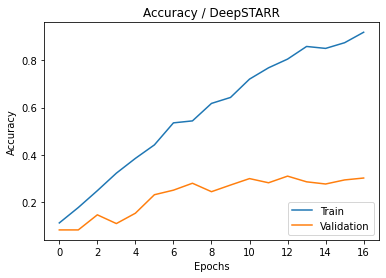

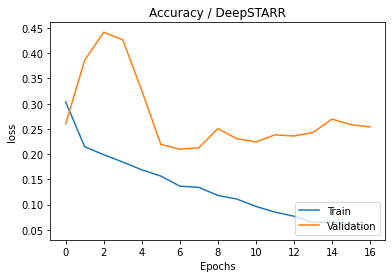

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy / DeepSTARR')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Accuracy / DeepSTARR')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

## Model Evaluation

In [5]:
model= json_hdf5_to_model('/g/data/zk16/xzhang/code/models/model_mouse17_deepSTARR_lr.json','/g/data/zk16/xzhang/code/models/model_mouse17_best_loss_class_deepSTARR_lr.hdf5')

# predict on test set and save values
p_test =model.predict(test_data)
np.save('deepSTARR_label',y_test)
np.save('deepSTATT_predict',p_test)

78/78 [==============================] - 2s 15ms/step


In [8]:
# Current Model predition
print('calculate roc and pr...')
roc_pr_dict = {"train": {}, "valid": {}, "test": {}}
roc_pr_dict["train"]["score"] = model.predict(train_data)
roc_pr_dict["train"]["label"] = y_train
roc_pr_dict["valid"]["score"] = model.predict(valid_data)
roc_pr_dict["valid"]["label"] = y_valid
roc_pr_dict["test"]["score"] = model.predict(test_data)
roc_pr_dict["test"]["label"] = y_test

# For each class, calculate ROC and auPR
for sets in ["train", "valid", "test"]:
    output = np.zeros((NUM_CLASSES,2))
    l = roc_pr_dict[sets]["label"]
    s = roc_pr_dict[sets]["score"]
    for i in range(NUM_CLASSES):
        roc = roc_auc_score(l.T[i],s.T[i])
        pr = average_precision_score(l.T[i],s.T[i])
        output[i] = [roc,pr]
    roc_pr_dict[sets]["roc_pr"] = output

calculate roc and pr...
78/78 [==============================] - 1s 10ms/step


### AUC /auPR plot across 17 cell-type

AVE_auc across 17 cell-type:  0.7154351655426563 AVE_auPR:  0.1843596001437413
auc for each cell-tyep on test set: 
 [0.68350228 0.74673416 0.90625586 0.8035676  0.58692178 0.66074827
 0.68918783 0.72279482 0.64059411 0.65996636 0.68594662 0.81363678
 0.66160823 0.71110625 0.77918755 0.75826707 0.65237225]
auPR for each cell-tyep on test set: 
 [0.06472248 0.21849804 0.71811221 0.27396356 0.01865835 0.0905735
 0.10808276 0.12839301 0.06626542 0.04264926 0.11037913 0.37298764
 0.1249157  0.05776648 0.36469938 0.27365776 0.0997885 ] 

auAUC / auPR on test datasets


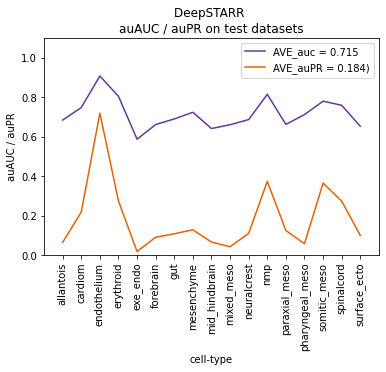

In [12]:
auc = roc_pr_dict["test"]["roc_pr"].T[0]

ave_auc = roc_pr_dict["test"]["roc_pr"].T[0].mean()
ave_pr = roc_pr_dict["test"]["roc_pr"].T[1].mean()
print("AVE_auc across 17 cell-type: ", ave_auc, "AVE_auPR: ", ave_pr)
print("auc for each cell-tyep on test set: \n",roc_pr_dict["test"]["roc_pr"].T[0])
print("auPR for each cell-tyep on test set: \n",roc_pr_dict["test"]["roc_pr"].T[1], "\n" )

# auc / auPR plot across 13 cell-types
Test_auc = roc_pr_dict["test"]["roc_pr"].T[0]
Test_pr = roc_pr_dict["test"]["roc_pr"].T[1]
X = np.array(list(range(NUM_CLASSES)))+1
cell_type = ['allantois','cardiom','endothelium', 'erythroid', 'exe_endo', 'forebrain', 'gut', 'mesenchyme', 'mid_hindbrain', 'mixed_meso', 'neuralcrest', 'nmp', 'paraxial_meso', 'pharyngeal_meso', 'somitic_meso', 'spinalcord', 'surface_ecto']
print('auAUC / auPR on test datasets')
plt.plot(X, Test_auc, color='#5D3A9B', label='auROC')
plt.plot(X, Test_pr, color='#E66100', label='auPR')
# plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('cell-type')
plt.ylabel('auAUC / auPR')
plt.ylim([0, 1.1])
plt.xlim([0, 18])
plt.title('DeepSTARR \nauAUC / auPR on test datasets')
y_pos = np.arange(len(cell_type))+1
plt.xticks(y_pos, cell_type)
plt.xticks(rotation=90)
plt.legend(['AVE_auc = 0.715', 'AVE_auPR = 0.184)'], loc='upper right')
plt.savefig('/home/114/xz3123/pdf/plot.pdf', bbox_inches='tight')
plt.show()


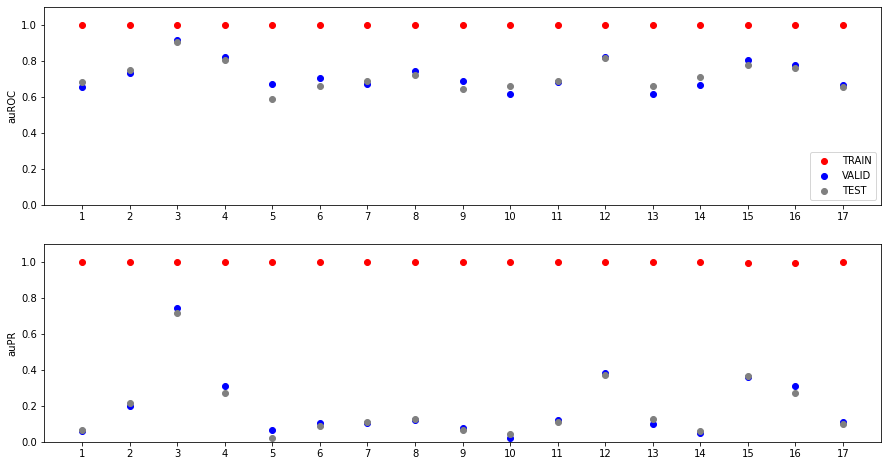

In [13]:
fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(2, 1, 1)
ax.set_ylabel('auROC')
ax.scatter(list(range(NUM_CLASSES)), roc_pr_dict["train"]["roc_pr"].T[0], color='red', label='TRAIN')
ax.scatter(list(range(NUM_CLASSES)), roc_pr_dict["valid"]["roc_pr"].T[0], color='blue', label='VALID')
ax.scatter(list(range(NUM_CLASSES)), roc_pr_dict["test"]["roc_pr"].T[0], color='gray', label='TEST')
ax.set_ylim([0, 1.1])
_ = plt.xticks(range(len(selected_classes)),range(1,len(selected_classes)+1))
ax.legend(loc='lower right')

ax = fig.add_subplot(2, 1, 2)
ax.set_ylabel('auPR')
ax.scatter(list(range(NUM_CLASSES)), roc_pr_dict["train"]["roc_pr"].T[1], color='red', label='TRAIN')
ax.scatter(list(range(NUM_CLASSES)), roc_pr_dict["valid"]["roc_pr"].T[1], color='blue', label='VALID')
ax.scatter(list(range(NUM_CLASSES)), roc_pr_dict["test"]["roc_pr"].T[1], color='gray', label='TEST')
ax.set_ylim([0, 1.1])
_ = plt.xticks(range(len(selected_classes)),range(1,len(selected_classes)+1))